In [ ]:
!git clone https://gitee.com/frontxiang/torch_adabob

In [ ]:
from ljp.optimizers.adabob import AdaBoB

optimizer = AdaBoB(model.parameters(), 
                 lr=0.001, 
                 betas=(0.9, 0.999),
                 final_lr=0.1,
                 gamma=1e-3)

for input, target in dataset:
    loss = model(input)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# Installing necesary libs

In [ ]:
!pip install -q gdown torchmetrics lpips torch-fidelity tqdm torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.9 MB/s eta 0:00:00


# Downloading needed Data

In [ ]:
!gdown 1m5dd3hd51p-EDHj05Pqsgspoiy5Gs6f_ # LAMA 36500
!gdown 1kUMW5pec4JVR0AKMkH49aoIOTGnnPmuP # MAT 0-17091
!gdown 154biIksdcBovAmEDvARfg5V1HPZQNZVP # MAT 17092-36500
!gdown 14-0t8X0pZBv_tyhs-PxNISdokKqO-aUN # MASKS 36500
!gdown 13otq0aAzCB9l9MIZpJhOJACIJeboS0NY # train data 20 each

Downloading...
From: https://drive.google.com/uc?id=1M_qtAZ0X7v97jZL3w6DM0zkXCcfztF-k
To: /content/till_now_best_unet.pth
100% 684k/684k [00:00<00:00, 80.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1K6JDi8l2QHYpHSmXZUYowEoFWAI60LYz
To: /content/till_now_best_denoising_lama.pth
100% 60.6k/60.6k [00:00<00:00, 66.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MoOIfk4j-1jrRIVDYgpmv6I_IixUYJIz
To: /content/till_now_best_denosingin_final.pth
100% 60.6k/60.6k [00:00<00:00, 56.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1m5dd3hd51p-EDHj05Pqsgspoiy5Gs6f_
From (redirected): https://drive.google.com/uc?id=1m5dd3hd51p-EDHj05Pqsgspoiy5Gs6f_&confirm=t&uuid=1d69f878-0f79-451d-b507-32b0f5f5a0ab
To: /content/lama_imgs_36500.zip
100% 548M/548M [00:11<00:00, 47.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1kUMW5pec4JVR0AKMkH49aoIOTGnnPmuP
From (redirected): https://drive.google.com/uc?id=1kUMW5pec4JVR0AKMkH49aoIOTGnnPmuP&confi

# Unzipping Data

In [3]:
#making the unzip function
import zipfile
import os

def unzip_file(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f'Extracted all files to {extract_to}')

In [4]:
#usng the unzip function
unzip_file("lama_imgs_36500.zip", "neww")
unzip_file("mat_imgs_17091.zip", "neww")
unzip_file("mat_images_17091_36500.zip", "neww")
unzip_file('masks.zip', 'neww')

Extracted all files to neww
Extracted all files to neww
Extracted all files to neww
Extracted all files to neww


# verifying Data size

In [11]:
print(len(os.listdir("neww/out_path_rg")))
print(len(os.listdir("neww/out_path")))

0
36421


In [7]:
print(len(os.listdir("neww/out_path_rg")) + len(os.listdir("neww/out_path")))

36421


# Moving data

In [10]:
import os
import shutil

source = '/content/neww/out_path_rg/'
destination = '/content/neww/out_path/'

# gather all files
allfiles = os.listdir(source)

# iterate on all files to move them to destination folder
for f in allfiles:
	src_path = os.path.join(source, f)
	dst_path = os.path.join(destination, f)
	shutil.move(src_path, dst_path)


# Downloading complete dataset from Pytorch

In [5]:
# downloading the dataset
import torchvision

train = torchvision.datasets.Places365(root = "data/", split = 'val', small = True, download = True )
train

100%|██████████| 67498496/67498496 [00:05<00:00, 13097705.60it/s]


Extracting data/filelist_places365-standard.tar to data/


100%|██████████| 525158400/525158400 [00:29<00:00, 17522197.82it/s]


Extracting data/val_256.tar to data/


Dataset Places365
    Number of datapoints: 36500
    Root location: data/
    Split: val
    Small: True

# Removing bad dim imgs from dataset

In [12]:
# reoving the wrong files
from pathlib import Path
import os
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

path = Path("data/val_256/")

# if we will use train data then it would have folders many of diff objects while in validation set there is no such complicaion
# removing the improper images
count = 0
for i in os.listdir(path):
  img = plt.imread(path/i)
  if img.shape[-1] != 3:
    os.remove(path/i)
    count += 1

print(f"Deleted images with incorrect number of dims : {count}")

Deleted images with incorrect number of dims : 79


# checking sizes of each data

In [14]:
# checking the number of each imgs
from pathlib import Path
import pandas as pd

path0 = Path("data/val_256/")
path = Path("neww/masks")
path2 = Path("neww/out_path")
path3 = Path("neww/test_images")

l0 = list(path0.glob("*.jpg"))
l1 = list(path.glob("*.jpg"))
l2 = list(path2.glob("*.png"))
l3 = list(path3.glob("*.jpg"))

l0.sort()
l1.sort()
l2.sort()
l3.sort()
print(len(l0),len(l1), len(l2), len(l3))

36421 36421 36421 36421


# checking path brekdown(depends on your setup)

In [ ]:
from pathlib import Path
meow = Path('/content/neww/train_images_20_each/')
imgs =  list(meow.glob("*.jpg"))

for i in imgs:
  name = i.as_posix().split("/")[-1].split(".")[0]
  print(i.as_posix().split("/"))
  print(i.as_posix().split("/")[-1])
  print(i.as_posix().split("/")[-1].split("."))
  print(name)
  break

['', 'content', 'neww', 'train_images_20_each', 'jacuzzi_indoor_00001518.jpg']
jacuzzi_indoor_00001518.jpg
['jacuzzi_indoor_00001518', 'jpg']
jacuzzi_indoor_00001518


# Making custom dataset class

In [19]:
# the custom dataset function
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
class inpainting_dataset(Dataset):
  """
  The path must be a PAthLib Path object
  """
  def __init__(self, path, transform = None, split : str = "train"):
    self.path = path
    self.transform = transform
    self.imgs =  list(self.path.glob("*.jpg"))

    self.path = Path("neww/test_images")
    self.lama_imgs = list(self.path.glob("*.jpg"))

    self.path = Path("neww/out_path")
    self.mat_imgs = list(self.path.glob("*.png"))

    self.path = Path("neww/masks/")
    self.masks = list(self.path.glob("*.jpg"))

    self.final = []
    for i in self.imgs:
      name = i.as_posix().split("/")[-1].split(".")[0]
      mat_name = "neww/out_path/" + name + ".png"    # for mat we have png format
      lama_name = "neww/test_images/" + name + ".jpg" # for lama we have jpg format
      mask_name = "neww/masks/" + name + ".jpg" # for masks

      if os.path.exists(mat_name) and os.path.exists(lama_name) and os.path.exists(mask_name):
        self.final.append(name)

      # self.imgs = self.final

    # self.train_imgs, self.val_imgs = train_test_split(self.final, test_size = 0.3,random_state = 42)
    # if split == "train":
    #   self.imgs = self.train_imgs
    # else:
    #   self.imgs = self.val_imgs
    self.imgs = self.final

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx): # self.final have onlyu names which will be used to just make the path of imgs
    name = self.imgs[idx]  # to get the path only

    img_n = "data/val_256/" + name + ".jpg"  # for image name
    mat = "neww/out_path/" + name + ".png"    # for mat we have png format
    lama = "neww/test_images/" + name + ".jpg" # for lama we have jpg format
    mask = "neww/masks/" + name + ".jpg" # for masks

    img = cv2.imread(img_n)
    img_lama = torch.tensor(cv2.imread(lama))
    mat_img = cv2.imread(mat)

    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    _, binary_mk = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    inv_mask = cv2.bitwise_not(binary_mk)

    img_back = cv2.bitwise_and(img, img, mask=inv_mask)
    img_fg = cv2.bitwise_and(mat_img, mat_img, mask=binary_mk)

    final_mat_img = img_back + img_fg

    return torch.tensor(img), img_lama, torch.tensor(final_mat_img) #i.e. correct image, lama and mat image

In [20]:
from torchvision import transforms
from pathlib import Path
path = Path("/content/data/val_256/")

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

# creating dataset

In [ ]:
# making the train and test dataset
train_dataset = inpainting_dataset(path, transform = transform, split = "train")
test_dataset = inpainting_dataset(path, transform = transform, split = "test")
train_dataset, test_dataset

(<__main__.inpainting_dataset at 0x7a1a3458fd90>,
 <__main__.inpainting_dataset at 0x7a1a33bbfa30>)

In [21]:
dataset = inpainting_dataset(path, transform = transform)
dataset

# Creating dataloader

In [22]:
dataloader = DataLoader(dataset, batch_size = 16,shuffle = False)
dataloader

In [ ]:
# making the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 16,shuffle = False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a1a342f6ce0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a1a342f45e0>)

# Plotting data

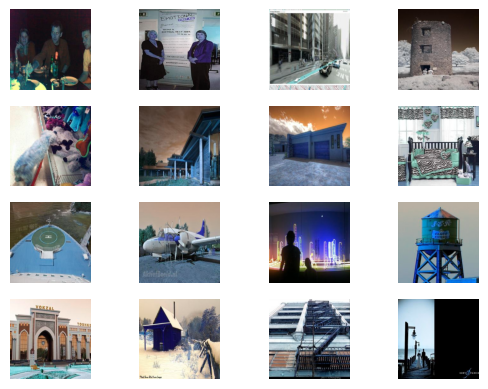

In [24]:
import torch
import matplotlib.pyplot as plt
# exploringg some data
z = next(iter(dataloader))

for i in range (16):
  plt.subplot(4,4,i+1)
  plt.axis("off")
  plt.imshow(z[2][i].detach().numpy())

In [ ]:
# len(dataloader) * 16

17056

# Defining Denoiser and Ensembler models

In [25]:
# the ensemble model --- PLAIN ONE
import torch
from torch import nn

class EnsembleModel(nn.Module):
  """
  This model will combine the output MAT and LAMA which will be saved in the model folder
  """
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, 3, 1, 1),
        nn.LeakyReLU(),
        # nn.MaxPool2d(2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(3, 32, 3, 1, 1),
        nn.LeakyReLU(),
        # nn.MaxPool2d(2),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),
        # nn.MaxPool2d(2),
    )

    self.in_conv3 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),

        nn.ConvTranspose2d(64, 32, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),

        nn.ConvTranspose2d(32, 3, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),
    )


  def forward(self, img1, img2):
    x = self.conv1(img1)
    y = self.conv2(img2)
    z = torch.cat((x, y), dim=1)
    z = self.conv3(z)
    z = self.in_conv3(z)
    return z


In [26]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        # self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        # self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 3, stride=1)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 3, stride=1)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 3, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        # x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        # x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        # x = self.pool(x)  # compressed representation

        ## decode ##
        # add transpose conv layers, with relu activation function
        # x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))

        return x

denoise = ConvDenoiser()

In [27]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Conv layer (3 --> 32 channels)
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)  # Conv layer (32 --> 16 channels)
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)  # Conv layer (16 --> 8 channels)

        ## decoder layers ##
        # Transpose layers to upsample back to the original input size
        self.t_conv1 = nn.ConvTranspose2d(8, 16, 3, padding=1)  # upsample by stride 1, no change in spatial dim
        self.t_conv2 = nn.ConvTranspose2d(16, 32, 3, padding=1)  # upsample by stride 1, no change in spatial dim
        self.t_conv3 = nn.ConvTranspose2d(32, 3, 3, padding=1)  # Output back to 3 channels

    def forward(self, x):
        ## encode ##
        x = F.leaky_relu(self.conv1(x))  # First conv layer
        x = F.leaky_relu(self.conv2(x))  # Second conv layer
        x = F.leaky_relu(self.conv3(x))  # Third conv layer

        ## decode ##
        x = F.leaky_relu(self.t_conv1(x))  # First transpose conv
        x = F.leaky_relu(self.t_conv2(x))  # Second transpose conv
        x = torch.sigmoid(self.t_conv3(x))  # Output layer with sigmoid activation

        return x

# Instantiate the model
denoise = ConvDenoiser()


In [ ]:
from torchinfo import summary
import torch
# Create an input tensor with the correct dimensions
input_tensor = torch.randn(16, 3, 256, 256)

# Pass the input tensor to denoise()
out = denoise(input_tensor)
out.shape

torch.Size([16, 3, 256, 256])

# Defining Loss Function

In [ ]:
# the loss function utility
import os
import torch
from collections import OrderedDict
from torch import nn as nn
from torchvision.models import vgg as vgg

class Registry():
    """
    The registry that provides name -> object mapping, to support third-party
    users' custom modules.

    To create a registry (e.g. a backbone registry):

    .. code-block:: python

        BACKBONE_REGISTRY = Registry('BACKBONE')

    To register an object:

    .. code-block:: python

        @BACKBONE_REGISTRY.register()
        class MyBackbone():
            ...

    Or:

    .. code-block:: python

        BACKBONE_REGISTRY.register(MyBackbone)
    """

    def __init__(self, name):
        """
        Args:
            name (str): the name of this registry
        """
        self._name = name
        self._obj_map = {}

    def _do_register(self, name, obj):
        assert (name not in self._obj_map), (f"An object named '{name}' was already registered "
                                             f"in '{self._name}' registry!")
        self._obj_map[name] = obj

    def register(self, obj=None):
        """
        Register the given object under the the name `obj.__name__`.
        Can be used as either a decorator or not.
        See docstring of this class for usage.
        """
        if obj is None:
            # used as a decorator
            def deco(func_or_class):
                name = func_or_class.__name__
                self._do_register(name, func_or_class)
                return func_or_class

            return deco

        # used as a function call
        name = obj.__name__
        self._do_register(name, obj)

    def get(self, name):
        ret = self._obj_map.get(name)
        if ret is None:
            raise KeyError(f"No object named '{name}' found in '{self._name}' registry!")
        return ret

    def __contains__(self, name):
        return name in self._obj_map

    def __iter__(self):
        return iter(self._obj_map.items())

    def keys(self):
        return self._obj_map.keys()


DATASET_REGISTRY = Registry('dataset')
ARCH_REGISTRY = Registry('arch')
MODEL_REGISTRY = Registry('model')
LOSS_REGISTRY = Registry('loss')
METRIC_REGISTRY = Registry('metric')

VGG_PRETRAIN_PATH = 'experiments/pretrained_models/vgg19-dcbb9e9d.pth'
NAMES = {
    'vgg11': [
        'conv1_1', 'relu1_1', 'pool1', 'conv2_1', 'relu2_1', 'pool2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2',
        'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2',
        'pool5'
    ],
    'vgg13': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'pool5'
    ],
    'vgg16': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2',
        'relu4_2', 'conv4_3', 'relu4_3', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3',
        'pool5'
    ],
    'vgg19': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3', 'conv4_1',
        'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4', 'conv5_1', 'relu5_1',
        'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5'
    ]
}


def insert_bn(names):
    """Insert bn layer after each conv.

    Args:
        names (list): The list of layer names.

    Returns:
        list: The list of layer names with bn layers.
    """
    names_bn = []
    for name in names:
        names_bn.append(name)
        if 'conv' in name:
            position = name.replace('conv', '')
            names_bn.append('bn' + position)
    return names_bn


@ARCH_REGISTRY.register()
class VGGFeatureExtractor(nn.Module):
    """VGG network for feature extraction.

    In this implementation, we allow users to choose whether use normalization
    in the input feature and the type of vgg network. Note that the pretrained
    path must fit the vgg type.

    Args:
        layer_name_list (list[str]): Forward function returns the corresponding
            features according to the layer_name_list.
            Example: {'relu1_1', 'relu2_1', 'relu3_1'}.
        vgg_type (str): Set the type of vgg network. Default: 'vgg19'.
        use_input_norm (bool): If True, normalize the input image. Importantly,
            the input feature must in the range [0, 1]. Default: True.
        range_norm (bool): If True, norm images with range [-1, 1] to [0, 1].
            Default: False.
        requires_grad (bool): If true, the parameters of VGG network will be
            optimized. Default: False.
        remove_pooling (bool): If true, the max pooling operations in VGG net
            will be removed. Default: False.
        pooling_stride (int): The stride of max pooling operation. Default: 2.
    """

    def __init__(self,
                 layer_name_list,
                 vgg_type='vgg19',
                 use_input_norm=True,
                 range_norm=False,
                 requires_grad=False,
                 remove_pooling=False,
                 pooling_stride=2):
        super(VGGFeatureExtractor, self).__init__()

        self.layer_name_list = layer_name_list
        self.use_input_norm = use_input_norm
        self.range_norm = range_norm

        self.names = NAMES[vgg_type.replace('_bn', '')]
        if 'bn' in vgg_type:
            self.names = insert_bn(self.names)

        # only borrow layers that will be used to avoid unused params
        max_idx = 0
        for v in layer_name_list:
            idx = self.names.index(v)
            if idx > max_idx:
                max_idx = idx

        if os.path.exists(VGG_PRETRAIN_PATH):
            vgg_net = getattr(vgg, vgg_type)(pretrained=False)
            state_dict = torch.load(VGG_PRETRAIN_PATH, map_location=lambda storage, loc: storage)
            vgg_net.load_state_dict(state_dict)
        else:
            vgg_net = getattr(vgg, vgg_type)(pretrained=True)

        features = vgg_net.features[:max_idx + 1]

        modified_net = OrderedDict()
        for k, v in zip(self.names, features):
            if 'pool' in k:
                # if remove_pooling is true, pooling operation will be removed
                if remove_pooling:
                    continue
                else:
                    # in some cases, we may want to change the default stride
                    modified_net[k] = nn.MaxPool2d(kernel_size=2, stride=pooling_stride)
            else:
                modified_net[k] = v

        self.vgg_net = nn.Sequential(modified_net).to(device)

        if not requires_grad:
            self.vgg_net.eval()
            for param in self.parameters():
                param.requires_grad = False
        else:
            self.vgg_net.train()
            for param in self.parameters():
                param.requires_grad = True

        if self.use_input_norm:
            # the mean is for image with range [0, 1]
            self.register_buffer('mean', torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device))
            # the std is for image with range [0, 1]
            self.register_buffer('std', torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device))

    def forward(self, x):
        """Forward function.

        Args:
            x (Tensor): Input tensor with shape (n, c, h, w).

        Returns:
            Tensor: Forward results.
        """
        if self.range_norm:
            x = (x + 1) / 2
        if self.use_input_norm:
            x = (x - self.mean) / self.std
        output = {}

        for key, layer in self.vgg_net._modules.items():
            x = layer(x)
            if key in self.layer_name_list:
                output[key] = x.clone()

        return output

In [ ]:
# actual loss function
import torch.nn.functional as F

class StyleLoss(nn.Module):

    def __init__(self):
        super(StyleLoss, self).__init__()

    def gram_matrix(self,input):
      a, b, c, d = input.size()  # a=batch size(=1)
      # b=number of feature maps
      # (c,d)=dimensions of a f. map (N=c*d)

      features = input.contiguous().view(a * b, c * d)  # resize F_XL into \hat F_XL

      G = torch.mm(features, features.t())  # compute the gram product

      # we 'normalize' the values of the gram matrix
      # by dividing by the number of element in each feature maps.
      return G.div(a * b * c * d)

    def forward(self, input, target1):
        G = self.gram_matrix(input)
        target = self.gram_matrix(target1).detach()
        self.loss = F.mse_loss(G, target)
        return self.loss

class PerceptualLoss(nn.Module):
    """Perceptual loss with commonly used style loss.

    Args:
        layer_weights (dict): The weight for each layer of vgg feature.
            Here is an example: {'conv5_4': 1.}, which means the conv5_4
            feature layer (before relu5_4) will be extracted with weight
            1.0 in calculting losses.
        vgg_type (str): The type of vgg network used as feature extractor.
            Default: 'vgg19'.
        use_input_norm (bool):  If True, normalize the input image in vgg.
            Default: True.
        range_norm (bool): If True, norm images with range [-1, 1] to [0, 1].
            Default: False.
      """

    def __init__(self,
                 layer_weights = {'conv1_2': 1, 'conv2_2': 1,'conv3_4': 1,'conv4_4': 1},
                 vgg_type='vgg19',
                 use_input_norm=True,
                 range_norm=True):
        super(PerceptualLoss, self).__init__()
        self.layer_weights = layer_weights
        self.vgg = VGGFeatureExtractor(
            layer_name_list=list(self.layer_weights.keys()),
            vgg_type=vgg_type,
            use_input_norm=use_input_norm,
            range_norm=range_norm)

        self.criterion = torch.nn.L1Loss()

    def forward(self, x, gt):
        """Forward function.

        Args:
            x (Tensor): Input tensor with shape (n, c, h, w).
            gt (Tensor): Ground-truth tensor with shape (n, c, h, w).

        Returns:
            Tensor: Forward results.
        """
        # extract vgg features
        x_features = self.vgg(x)
        gt_features = self.vgg(gt.detach())

        # calculate perceptual loss
        percep_loss = 0
        for k in x_features.keys():
            percep_loss += self.criterion(x_features[k], gt_features[k]) * self.layer_weights[k]

        return percep_loss


# def l1_loss():   -> take direct from premade
#   pass

class EdgeLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(EdgeLoss, self).__init__()
        k = torch.Tensor([[.05, .25, .4, .25, .05]])
        self.kernel = torch.matmul(k.t(),k).unsqueeze(0).repeat(3,1,1,1).to(device)

    def conv_gauss(self, img):
        n_channels, _, kw, kh = self.kernel.shape
        img = F.pad(img, (kw//2, kh//2, kw//2, kh//2), mode='replicate')
        return F.conv2d(img, self.kernel, groups=n_channels)

    def laplacian_kernel(self, current):
        filtered    = self.conv_gauss(current)
        down        = filtered[:,:,::2,::2]
        new_filter  = torch.zeros_like(filtered)
        new_filter[:,:,::2,::2] = down*4
        filtered    = self.conv_gauss(new_filter)
        diff = current - filtered
        return diff

    def forward(self, x, y):
        loss = F.mse_loss(self.laplacian_kernel(x), self.laplacian_kernel(y))
        return loss

class CombinedLoss(nn.Module):
    def __init__(self, device = "cpu"):
        super(CombinedLoss, self).__init__()
        self.edge_loss = EdgeLoss().to(device)
        self.mse_loss = nn.MSELoss().to(device)  # l1 loss
        self.style_loss = StyleLoss().to(device)
        self.perceptual_loss = PerceptualLoss().to(device)

    def forward(self, gen_img, gt_img):
        gen_img.to(device)
        gt_img.to(device)
        edge_loss_value = self.edge_loss(gen_img, gt_img)
        mse_loss_value = self.mse_loss(gen_img, gt_img)
        style_loss_value = self.style_loss(gen_img, gt_img)
        perceptual_loss_value = self.perceptual_loss(gen_img, gt_img)
        total_loss = edge_loss_value + mse_loss_value + style_loss_value + perceptual_loss_value
        return total_loss


# Training the denoising model

In [ ]:
# initialize the NN
denoising_model = ConvDenoiser()
criterion = nn.MSELoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

# specify loss function
denoising_optimizer = torch.optim.Adam(denoising_model.parameters(), lr=0.001)

In [ ]:
# actual training
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm

NUM_EPOCHS = 5

denoising_model.to(device)

print(type(denoising_model))
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = 0
  denoising_model.train()
  for num,(img, lama, mat) in tqdm(enumerate(train_dataloader)):
    img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

    pred = denoising_model(lama)

    loss = criterion(pred, img/255.0)  # for RGB color space
    train_loss += loss.item()

    denoising_optimizer.zero_grad()
    loss.backward()
    denoising_optimizer.step()

  test_loss = 0
  denoising_model.eval()
  with torch.inference_mode():
    for num ,(img, lama, mat) in tqdm(enumerate(test_dataloader)):
      img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

      pred = denoising_model(lama)
      loss = criterion(pred, img/255.0)

      test_loss += loss.item()

  test_loss /= len(test_dataloader)
  train_loss /= len(train_dataloader)

  if epoch%1 == 0:
    torch.save(denoising_model, f"denoising_model_epoch_{epoch}.pth")
    print(f'\nepoch : {epoch} || train loss : {train_loss} || test loss : {test_loss}')

<class '__main__.ConvDenoiser'>


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 0 || train loss : 0.016941129595215897 || test loss : 0.01404370358009843


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 1 || train loss : 0.011068629934743512 || test loss : 0.011162972512797718


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 2 || train loss : 0.010662811965448781 || test loss : 0.01132169475330271


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 3 || train loss : 0.010310523486987222 || test loss : 0.010431116813943334


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 4 || train loss : 0.010067124229681212 || test loss : 0.00982451042921765


In [ ]:
torch.save(denoising_model,'final_lama_denoiser_20_each_model.pth')

# training the denoising model on output of ensembler


In [ ]:
# training hyperparams
from torch.optim import Adam
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# model = EnsembleModel()
# model = torch.load("best_unet_with_denois.pth").to(device)
model.to(device)

denoising_model_lama = denoising_model
denoising_model = ConvDenoiser()
# denoising_model_lama = torch.load("denoising_model_good.pth")

loss_fn = nn.MSELoss()

denoising_optimizer = torch.optim.Adam(denoising_model.parameters(), lr=0.001)

In [ ]:
# actual training
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm

NUM_EPOCHS = 5

model.to(device)
denoising_model.to(device)
denoising_model_lama.to(device)

model.eval()
denoising_model_lama.eval()

print(type(denoising_model))
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = 0
  denoising_model.train()
  for num,(img, lama, mat) in tqdm(enumerate(train_dataloader)):
    img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

    pred = denoising_model(model(denoising_model_lama(lama), mat))

    loss = loss_fn(pred*255.0, img)  # for RGB color space
    train_loss += loss.item()

    denoising_optimizer.zero_grad()
    loss.backward()
    denoising_optimizer.step()

  test_loss = 0
  denoising_model.eval()
  with torch.inference_mode():
    for num ,(img, lama, mat) in tqdm(enumerate(test_dataloader)):
      img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

      pred = denoising_model(model(denoising_model_lama(lama), mat))
      loss = loss_fn(pred*255.0, img)

      test_loss += loss.item()

  test_loss /= len(test_dataloader)
  train_loss /= len(train_dataloader)

  if epoch%1 == 0:
    torch.save(model, f"model_epoch_{epoch}.pth")
    print(f'\nepoch : {epoch} || train loss : {train_loss} || test loss : {test_loss}')

<class '__main__.ConvDenoiser'>


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 0 || train loss : 37.19741986393929 || test loss : 26.772155427584682


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 1 || train loss : 28.608769989013673 || test loss : 51.24729482274856


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 2 || train loss : 35.74992837309837 || test loss : 62.97917988352532


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 3 || train loss : 27.858033204078673 || test loss : 23.273786537838678


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 4 || train loss : 29.454568156599997 || test loss : 31.74075513686577


In [ ]:
torch.save(denoising_model, 'final_best_denoising_model_for_final_20_each.pth') #epoch : 4 || train loss : 32.621086430549624 || test loss : 36.331669563794655

# Training the ensemble model

In [ ]:
# training hyperparams
# OPTIMZER AND OTHER SETTINGS FOR TRAINING
from torch.optim import Adam
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = CombinedLoss(device = device).to(device)
# rgb_to_hvi = RGB_HVI() another possibilty for modification

model = EnsembleModel()
model.to(device)
# model = torch.load("best_unet_with_denois.pth", map_location=torch.device('cpu')) #.to(device)

optimizer = Adam(model.parameters(), lr=1e-4)
# denoising_model = torch.load("denoising_model_good.pth", map_location=torch.device('cpu'))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 164MB/s]


In [ ]:
# actual training
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm

NUM_EPOCHS = 5

model.to(device)
denoising_model.to(device)

denoising_model.eval()
print(type(model))
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = 0
  model.train()
  for num,(img, lama, mat) in tqdm(enumerate(train_dataloader)):
    img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

    pred = model(denoising_model(lama), mat)

    loss = loss_fn(pred, img)  # for RGB color space
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  test_loss = 0
  model.eval()
  with torch.inference_mode():
    for num ,(img, lama, mat) in tqdm(enumerate(test_dataloader)):
      img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

      pred = model(denoising_model(lama), mat)
      loss = loss_fn(pred, img)

      test_loss += loss.item()

  test_loss /= len(test_dataloader)
  train_loss /= len(train_dataloader)

  if epoch%1 == 0:
    torch.save(model, f"model_epoch_{epoch}.pth")
    print(f'\nepoch : {epoch} || train loss : {train_loss} || test loss : {test_loss}')
    #epoch : 4 || train loss : 304.2973921775818 || test loss : 273.30257599545223

<class '__main__.EnsembleModel'>


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 0 || train loss : 186.20889506340026 || test loss : 266.8143245947622


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 1 || train loss : 163.13426456451415 || test loss : 5570.16451870438


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 2 || train loss : 290.2673897504807 || test loss : 170.67395253425096


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 3 || train loss : 142.64175164699554 || test loss : 142.48533535699775


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 4 || train loss : 134.56529126167297 || test loss : 2530.320282205178


In [ ]:
pred

tensor([[[0.4133, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0508, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

# Saving the trained models

In [ ]:
torch.save(model, 'best_unet_with_denois_20_each.pth')

In [ ]:
torch.save(denoising_model, 'denoising_model_good.pth')